# DTSA 5509: Beer ML Project

## Project Overview

In [192]:
#Importing Libraries and Packages
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import requests
from io import StringIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


## Beer Profile Ratings Data Set

In [94]:
#Reading in Dataframe from project github repository
url = 'https://raw.githubusercontent.com/JSchlangen9/ML-Beer/main/beer_profile_and_ratings.csv'
file = requests.get(url)
string_data = StringIO(file.text)

df = pd.read_csv(string_data)

df.head()

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


## Data Cleaning

In [95]:
#Dropping unnedded columns and removing Max IBU values == 0
df = df.drop(['Name', 'Brewery', 'Beer Name (Full)', 'Description'], axis=1)
df = df[df['Max IBU'] > 0]

#Manually Classifying Beer into 10 common categories and removing other records
beer_categories = ['Ale', 'Bock', 'Bitter', 'IPA', 'Lager', 'Pilsner', 'Porter', 'Sour', 'Stout', 'Wheat Beer']

for cat in beer_categories:
    df.loc[df['Style'].str.contains(cat), 'Style'] = cat

df = df[df['Style'].isin(beer_categories)]

df.describe()

,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
count,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000
mean,6.483593,22.517339,39.804032,16.786290,48.872581,16.156048,39.918548,56.645161,30.730645,1.056048,35.225806,43.558871,15.636694,80.054839,3.612744,3.753474,3.650307,3.691706,3.750649,243.394758
std,2.434846,12.201701,19.875863,9.861091,26.730648,16.187618,25.902488,31.060974,32.486036,2.227230,30.074625,30.340008,18.593675,38.702382,0.503906,0.403362,0.441199,0.503283,0.429636,370.835830
min,0.000000,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.509615,1.827916,1.682692,1.355769,1.471154,1.000000
25%,5.000000,15.000000,25.000000,10.000000,30.000000,6.000000,20.000000,33.000000,10.000000,0.000000,11.000000,21.000000,4.000000,50.000000,3.386364,3.605110,3.462121,3.476605,3.571337,27.000000
50%,5.800000,20.000000,35.000000,15.000000,42.000000,11.000000,35.000000,53.000000,20.000000,0.000000,26.000000,36.000000,10.000000,77.500000,3.693650,3.833333,3.728772,3.782763,3.833333,100.000000
75%,7.500000,25.000000,45.000000,22.000000,61.000000,20.000000,56.000000,74.000000,40.000000,1.000000,54.000000,58.000000,20.000000,107.000000,3.958333,4.000000,3.951476,4.017862,4.029978,296.250000
max,57.500000,65.000000,100.000000,77.000000,175.000000,126.000000,150.000000,217.000000,238.000000,48.000000,175.000000,172.000000,173.000000,239.000000,4.750000,4.625000,4.666667,5.000000,4.807692,3290.000000


## Exploratory Data Analysis

<Axes: >

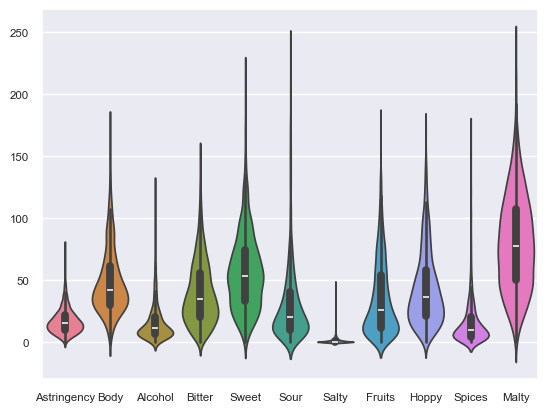

In [112]:
#Creating Violin Plot for Flavor Attributes
flavor_df = df[['Astringency', 'Body', 'Alcohol', 'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty']]

sns.set_theme(font_scale=0.75)
sns.violinplot(flavor_df)

<Axes: >

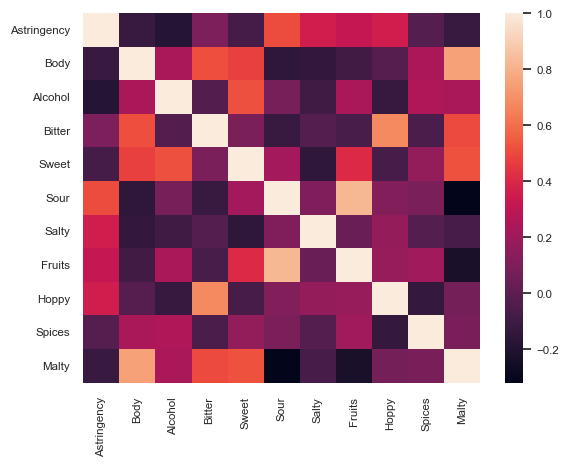

In [127]:
#Creating Correlation Heatmap for Flavor Attributes
sns.heatmap(flavor_df.corr())

<Axes: >

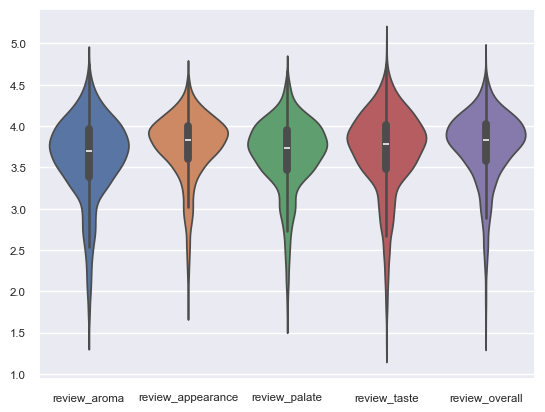

In [113]:
#Creating Violin Plot for Review Attributes
review_df = df[['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'review_overall']]

sns.set_theme(font_scale=0.75)
sns.violinplot(review_df)

<Axes: >

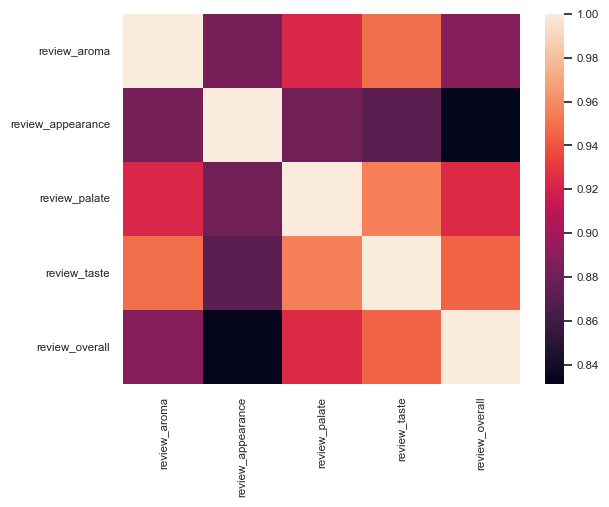

In [115]:
#Creating Correlation Heatmap for Review Attributes
sns.heatmap(review_df.corr())

## Model Testing & Selection

In [159]:
x = np.array(df.drop(['Style'], axis=1))
y = np.array(df['Style'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(x_train, y_train)

sv = SVC()
sv.fit(x_train, y_train)

rf_acc = accuracy_score(y_test, rf.predict(x_test))
sv_acc = accuracy_score(y_test, sv.predict(x_test))

print('Random Forest Accuracy:', rf_acc)
print('Support Vector Accuracy:', sv_acc)

Random Forest Accuracy: 0.8266129032258065
Support Vector Accuracy: 0.5383064516129032


In [162]:
model = RandomForestClassifier(n_estimators=1000, max_features=10)
model.fit(x_train, y_train)

model_acc = accuracy_score(y_test, model.predict(x_test))

print('Random Forest (Tuned) Accuracy:', model_acc)

Random Forest (Tuned) Accuracy: 0.8366935483870968


<Axes: title={'center': 'Feature Importance'}, ylabel='Impurity Decrease'>

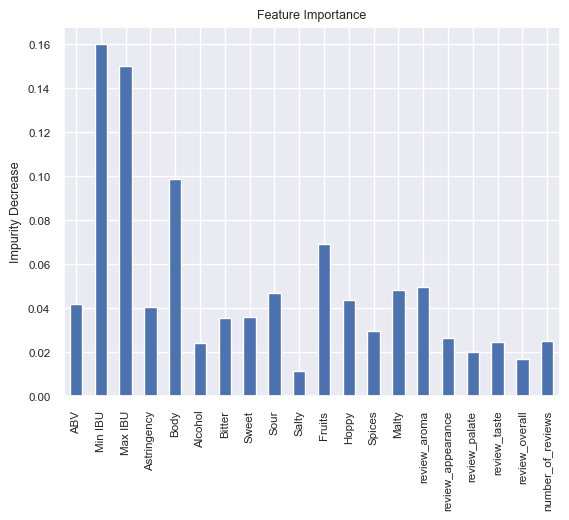

In [178]:
imp = model.feature_importances_
feat = df.drop(['Style'], axis=1).columns.unique().tolist()

model_imp = pd.Series(imp, index=feat)

model_imp.plot.bar(title='Feature Importance', ylabel='Impurity Decrease')

## Results & Conclusion

In [187]:
model_comp = completeness_score(y_test, model.predict(x_test))
model_hom = homogeneity_score(y_test, model.predict(x_test))

print('Random Forest (Tuned) Accuracy:', model_acc)
print('Random Forest (Tuned) Completeness:', model_comp)
print('Random Forest (Tuned) Homegeneity:', model_hom)

Random Forest (Tuned) Accuracy: 0.8366935483870968
Random Forest (Tuned) Completeness: 0.6764379761358932
Random Forest (Tuned) Homegeneity: 0.6721904561221569


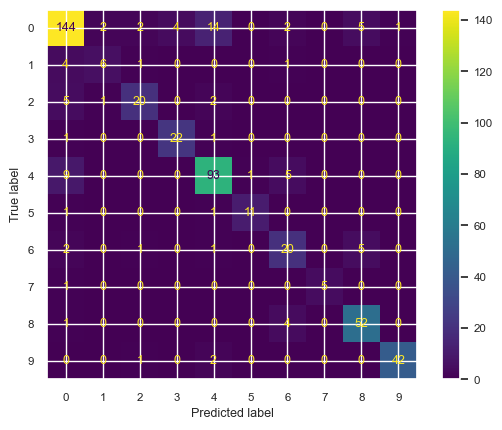

In [193]:
model_cm = confusion_matrix(y_test, model.predict(x_test))
model_disp = ConfusionMatrixDisplay(model_cm)

model_disp.plot()
plt.show()